In [45]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from nistats import hemodynamic_models
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize

In [2]:
n_volumes = 200
t_r = 2

In [32]:
def dct_basis(n, k):
    '''Creates basis functions for Discrete Cosine Transform (DCT).'''
    X = np.zeros((n, k))
    for i in range(k):
        X[:, i] = np.sqrt(2 / n) * np.cos(np.pi * np.arange(n) * i / n)
    return X

def convolve(signal, oversampling=50, t_r=2):
    '''Convolve signal with spm double-gamma HRF.'''
    n_volumes = len(signal)
    frame_times = np.arange(0, n_volumes * t_r, t_r)
    onsets = np.zeros((3, n_volumes))
    for vol, amplitude in enumerate(signal):
        onsets[:, vol] = (vol * t_r, 0, amplitude)

    signal_bold = hemodynamic_models.compute_regressor(
        onsets,
        'spm',                              
        frame_times,
        oversampling=oversampling,     
        fir_delays=None)[0].ravel()

    return signal_bold

# Create cosine basis set
X = dct_basis(n_volumes, n_volumes)

# Convolve basis set with HRF
HX = np.zeros(X.shape)
for i, xi in enumerate(X):
    HX[:, i] = convolve(xi)

def deconvolve(signal, alpha):
    lin = Ridge(
        alpha=alpha,
        solver='lsqr',
        fit_intercept=False,
        normalize=False,
        max_iter=1000
    )
    lin.fit(HX, signal)
    return np.matmul(X, lin.coef_) 

def noisify(signal, fract=0.1):
    '''Add Gaussian noise to the signal'''
    return signal + np.random.randn(len(signal)) * np.std(signal) * fract

def normalize_1d(signal):  
    return normalize(signal[:, np.newaxis], axis=0).ravel()

## Create simulated response

Here, simulated neural response to sparsely placed events (5% volumes) is calculated. Neural response is then convolved with a standard double-gamma SPM hrf and plotted for different levels of Gaussian noise. Gaussian noise have standard deviation that is either 50 or 100% of BOLD signal standard deviation.

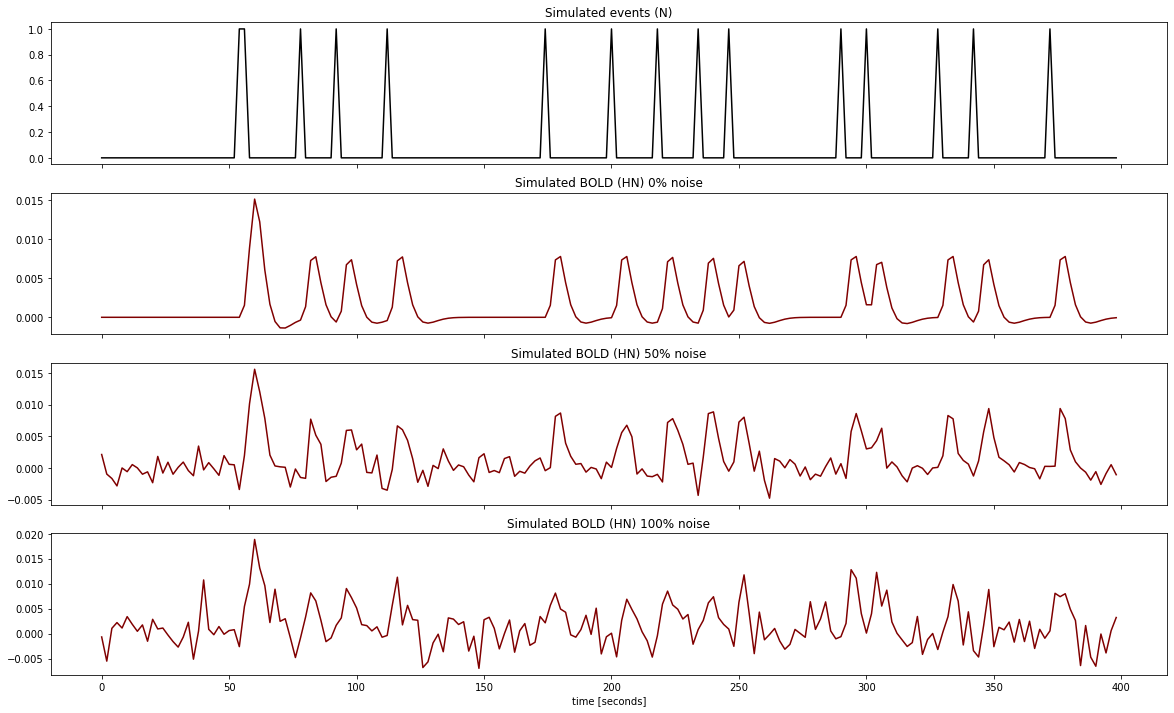

In [72]:
np.random.seed(5)

# Create neural response
events = (np.random.random(n_volumes) > .95) * 1

time = np.arange(0, n_volumes * t_r, t_r)
bold = {noise: noisify(convolve(events), noise) for noise in [0, 0.25, 0.5, 0.75, 1]}

fig, ax = plt.subplots(figsize=(20, 12), nrows=4, sharex=True)

ax[0].plot(time, events, 'k')
ax[0].set_title('Simulated events (N)')

ax[1].plot(time, bold[0], 'maroon')
ax[1].set_title('Simulated BOLD (HN) 0% noise')

ax[2].plot(time, bold[.5], 'maroon')
ax[2].set_title('Simulated BOLD (HN) 50% noise')

ax[3].plot(time, bold[1], 'maroon')
ax[3].set_title('Simulated BOLD (HN) 100% noise')

ax[-1].set_xlabel('time [seconds]')
plt.show()

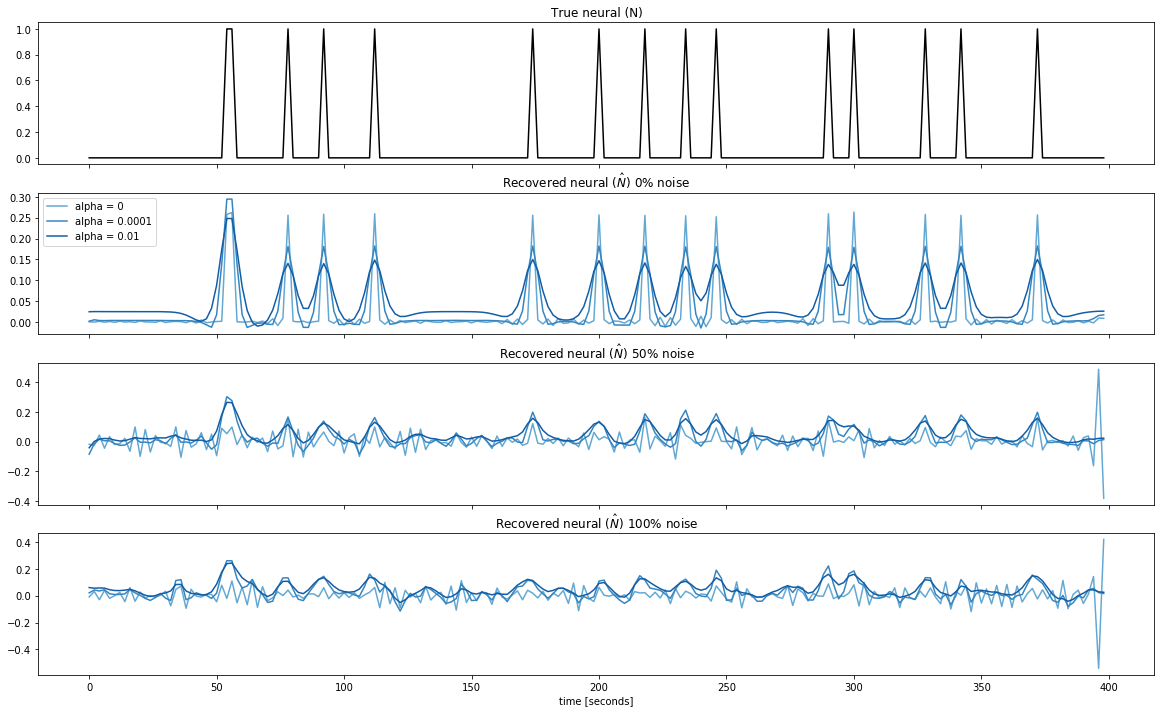

In [70]:
time = np.arange(0, n_volumes * t_r, t_r)

fig, ax = plt.subplots(figsize=(20, 12), nrows=4, sharex=True)
cmap = matplotlib.cm.get_cmap('Blues')

ax[0].plot(time, events, 'k')
ax[0].set_title('True neural (N)')

for i, alpha in enumerate([0, 0.0001, 0.01]):

    neur = {noise: deconvolve(signal, alpha) for noise, signal in bold.items()}

    ax[1].plot(time, normalize_1d(neur[0]), color=cmap(0.75 + (i - 1.5) * .15), label=f"alpha = {alpha}")
    ax[1].set_title('Recovered neural ($\hat{N}}$) 0% noise')

    ax[2].plot(time, normalize_1d(neur[.5]), color=cmap(0.75 + (i - 1.5) * .15))
    ax[2].set_title('Recovered neural ($\hat{N}}$) 50% noise')

    ax[3].plot(time, normalize_1d(neur[1]), color=cmap(0.75 + (i - 1.5) * .15))
    ax[3].set_title('Recovered neural ($\hat{N}}$) 100% noise')

    ax[-1].set_xlabel('time [seconds]')

ax[1].legend()
plt.show()

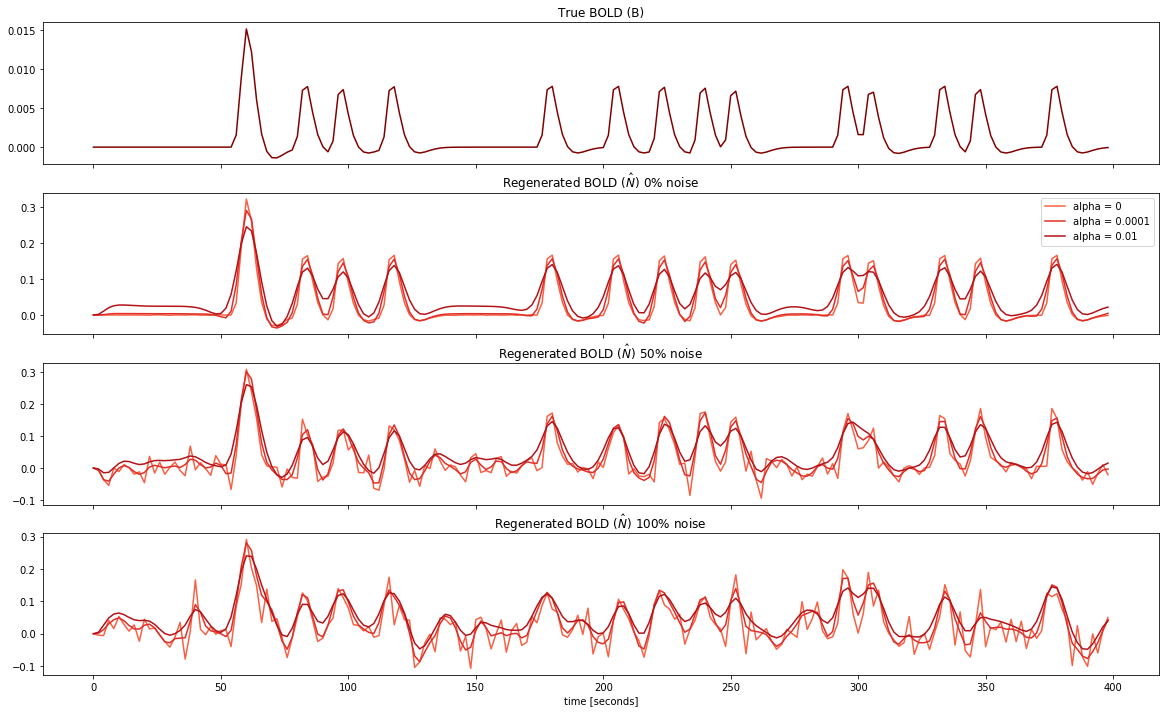

In [74]:
time = np.arange(0, n_volumes * t_r, t_r)

fig, ax = plt.subplots(figsize=(20, 12), nrows=4, sharex=True)
cmap = matplotlib.cm.get_cmap('Reds')

ax[0].plot(time, bold[0], 'maroon')
ax[0].set_title('True BOLD (B)')

for i, alpha in enumerate([0, 0.0001, 0.01]):

    regen = {noise: convolve(deconvolve(signal, alpha)) for noise, signal in bold.items()}

    ax[1].plot(time, normalize_1d(regen[0]), color=cmap(0.75 + (i - 1.5) * .15), label=f"alpha = {alpha}")
    ax[1].set_title('Regenerated BOLD ($\hat{N}}$) 0% noise')

    ax[2].plot(time, normalize_1d(regen[.5]), color=cmap(0.75 + (i - 1.5) * .15))
    ax[2].set_title('Regenerated BOLD ($\hat{N}}$) 50% noise')

    ax[3].plot(time, normalize_1d(regen[1]), color=cmap(0.75 + (i - 1.5) * .15))
    ax[3].set_title('Regenerated BOLD ($\hat{N}}$) 100% noise')

    ax[-1].set_xlabel('time [seconds]')

ax[1].legend()
plt.show()